### Various factors as predictors for diabetes

Joseph Gao, Kirsten Husdal, Tony Lee and Irene Wan

### Introduction

Diabetes is a chronic condition characterized by the dysregulation of blood glucose due to abnormal insulin levels. (World Health Organization, 2022). There are two etiologies for diabetes: Type 1, an autoimmune disorder, occurs when the pancreas has reduced insulin production, whereas Type 2 is a result of decreased insulin sensitivity (Diabetes Canada, 2022). Accounting for 95% of all current diagnoses, Type 2 diabetes develops in adulthood and is comorbid with factors such as high blood pressure, high BMI and family history (Diabetes Canada, 2022). This project will explore the correlations between diabetes, and comorbid factors in an effort to produce a diagnostic tool. 

diabetes.csv contains a subset of observations collected from a larger database generated by the National Institute of Diabetes and Digestive and Kidney Diseases. The data was collected from 2016 to 2022, with all participants being females of Pima Indian heritage over 21 years of age (Khare, 2022).

The dataset has the following variables:

* `Pregnancies` – number of pregnancies
* `Glucose` – blood glucose level (mg/dL)
* `BloodPressure` – diastolic blood pressure (mm/Hg)
* `SkinThickness` – triceps skinfold thickness (mm)
* `Insulin` – insulin level in the blood (IU/mL)
* `BMI` – body mass index (kg/m2)
* `DiabetesPedigreeFunction` – likelihood of diabetes based on family history
* `Age`
* `Outcome` – whether or not the individual has diabetes (1 = yes, 0 = no)


We will investigate if it is possible to predict the outcome (if an individual has diabetes or not) given the other variables in the dataset.


### Methods

In [1]:
# install leaps library
# to perform predictor subset selection
install.packages("leaps")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [2]:
# Load libraries
library(tidyverse)
library(tidymodels)
library(ggplot2)
library(readr)
library(leaps)
library(patchwork)
# Limiting visible table rows
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

After examining the data, there are no rows that require cleaning. However, there are values where zero was applied as a placeholder when the value was not collected. These zeroes are found in Glucose, BloodPressure, SkinThickness, Insulin, BMI, DiabetesPedigreeFunction and Age. To prevent them from influencing final calculations, these values will be filtered out. 

In [3]:
#Filtering data

urlfile <- "https://raw.githubusercontent.com/hsgao12/dsci-100-group-132/main/data/diabetes.csv"

# Set constant seed setting later seeds
SEED = 2022

diabetes_data <- read_csv(url(urlfile)) |>
                mutate(Outcome = as_factor(Outcome)) |>
                filter(Glucose != 0) |> 
                filter(BloodPressure != 0) |> 
                filter(SkinThickness != 0) |> 
                filter(Insulin != 0) |> 
                filter(BMI != 0) |> 
                filter(Age != 0) |> 
                filter(DiabetesPedigreeFunction != 0)

diabetes_data

Rows: 768 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, D...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,89,66,23,94,28.1,0.167,21,0
0,137,40,35,168,43.1,2.288,33,1
3,78,50,32,88,31.0,0.248,26,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
2,88,58,26,16,28.4,0.766,22,0
10,101,76,48,180,32.9,0.171,63,0
5,121,72,23,112,26.2,0.245,30,0


**Table 1.** Diagnostic factors, demographic information and diagnosis of patients

In [4]:
set.seed(SEED)

obs_num_outcome <- diabetes_data |>
                    group_by(Outcome) |>
                    summarize(num_obs = n())

obs_num_outcome

Outcome,num_obs
<fct>,<int>
0,262
1,130


**Table 2.** Diagnosis of patients

Outcome(1) = diagnosis, Outcome(0) = no diagnosis, num_obs = number of observations.

In [5]:
set.seed(SEED)

# splitting the data into 75% training data and 25% testing data
diabetes_split <- initial_split(diabetes_data, prop = 0.75, strata = Outcome)
diabetes_train <- training(diabetes_split)
diabetes_test <- testing(diabetes_split)

diabetes_train

diabetes_test

diagnosis_means_predictors <- diabetes_train |>
    filter(Outcome == 1) |>
    select(-Outcome) |>
    map_df(mean)
diagnosis_means_predictors

no_diagnosis_means_predictors <- diabetes_train |>
    filter(Outcome == 0) |>
    select(-Outcome) |>
    map_df(mean)
no_diagnosis_means_predictors

Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,89,66,23,94,28.1,0.167,21,0
3,126,88,41,235,39.3,0.704,27,0
1,97,66,15,140,23.2,0.487,22,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
11,120,80,37,150,42.3,0.785,48,1
3,187,70,22,200,36.4,0.408,36,1
1,128,88,39,110,36.5,1.057,37,1


Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
5,166,72,19,175,25.8,0.587,51,1
1,103,30,38,83,43.3,0.183,33,0
10,125,70,26,115,31.1,0.205,41,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
3,102,44,20,94,30.8,0.400,26,0
1,109,58,18,116,28.5,0.219,22,0
0,181,88,44,510,43.3,0.222,26,1


Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
4.597938,144.6082,73.91753,32.26804,207.0825,35.19175,0.6155773,35.97938


Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2.72449,108.7959,69.37755,27.45408,121.2143,31.98112,0.4588112,28.07653


**Table 3.** Training data summary

**Table 4.** Testing data summary

**Table 5.** Mean values of predictors in patients with a diabetes diagnosis.

**Table 6.** Mean values of predictors in patients without a diabetes diagnosis.
* As we can see in Tables 5 and 6, the mean values for all predictors are higher in patients with diabetes, however more analysis must be done to determine which predictors are significant in classifying observations.

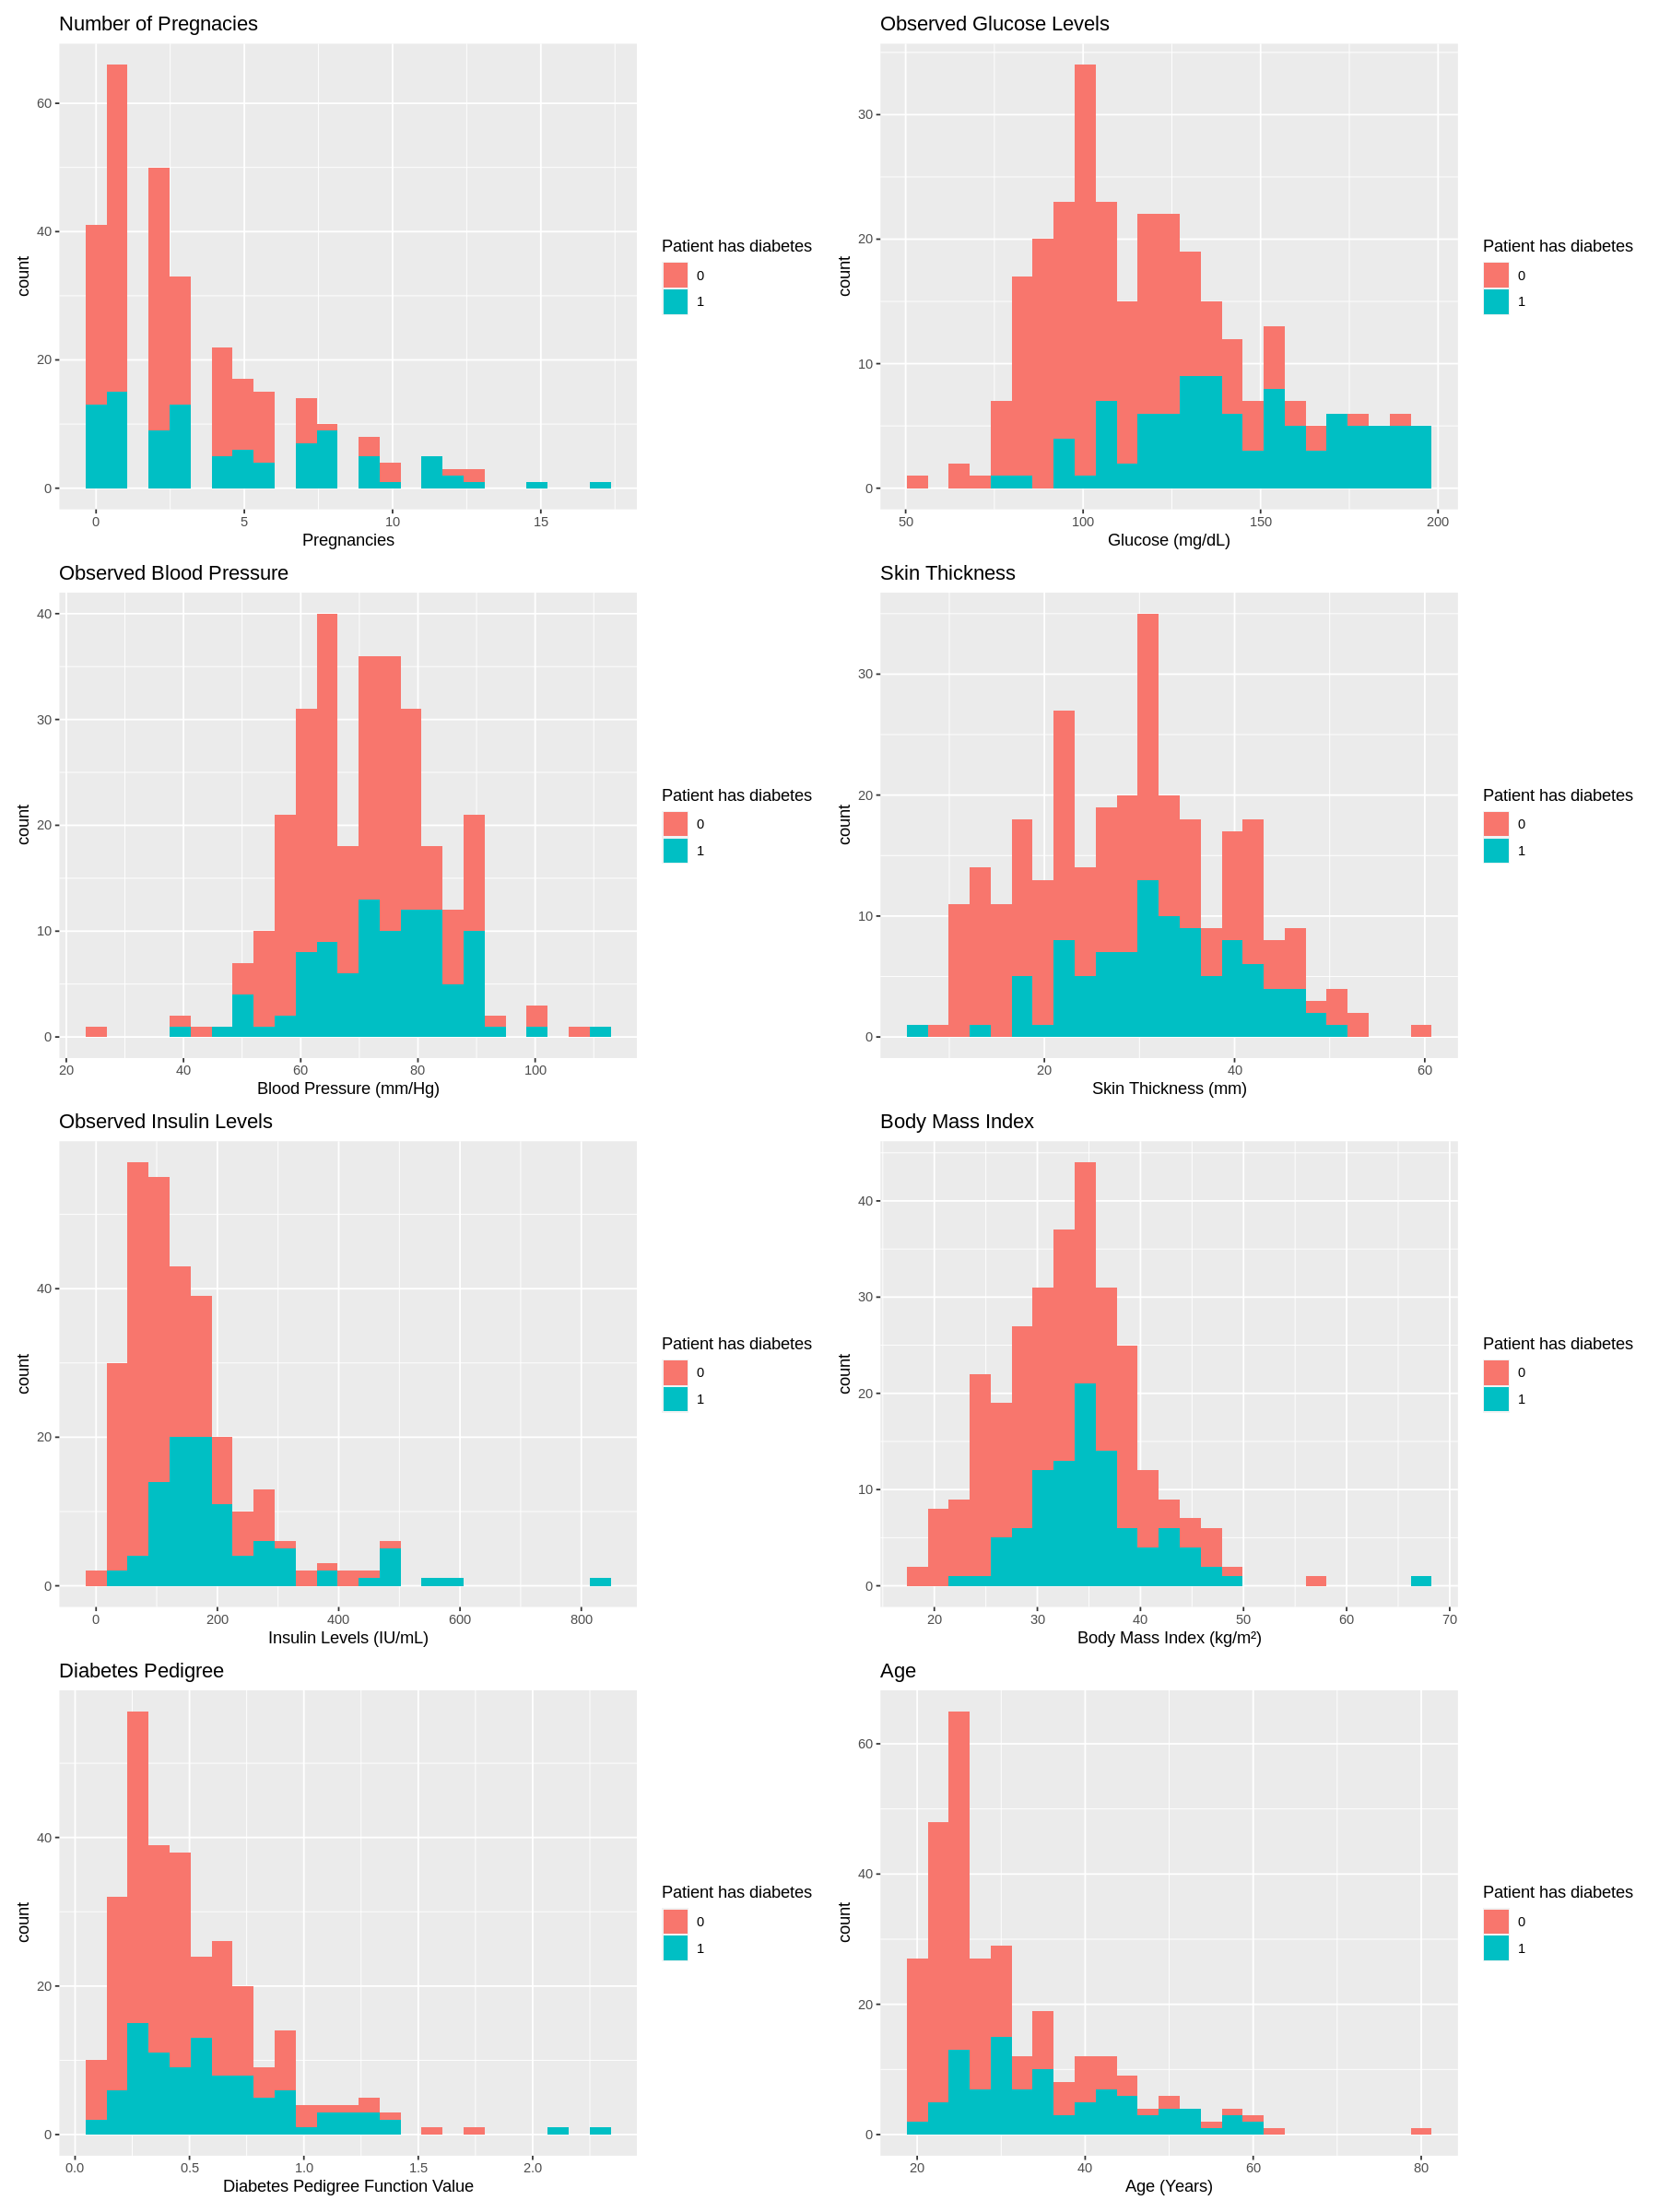

In [6]:
# Producing figures to help visually isolate predictive factor relationships

options(repr.plot.width = 15, repr.plot.height = 20) 

p1 <- ggplot(diabetes_train, aes(x=Pregnancies, fill=Outcome)) + 
    geom_histogram(position="stack", bins=25) + 
    labs(x="Pregnancies", fill="Patient has diabetes") +
    ggtitle("Number of Pregnacies")

p2 <- ggplot(diabetes_train, aes(x=Glucose, fill=Outcome)) + 
    geom_histogram(position="stack", bins=25) + 
    labs(x="Glucose (mg/dL)", fill="Patient has diabetes") +
    ggtitle("Observed Glucose Levels")

p3 <- ggplot(diabetes_train, aes(x=BloodPressure, fill=Outcome)) + 
    geom_histogram(position="stack", bins=25) + 
    labs(x="Blood Pressure (mm/Hg)", fill="Patient has diabetes") +
    ggtitle("Observed Blood Pressure")

p4 <- ggplot(diabetes_train, aes(x=SkinThickness, fill=Outcome)) + 
    geom_histogram(position="stack", bins=25) + 
    labs(x="Skin Thickness (mm)", fill="Patient has diabetes") +
    ggtitle("Skin Thickness")

p5 <- ggplot(diabetes_train, aes(x=Insulin, fill=Outcome)) + 
    geom_histogram(position="stack", bins=25) + 
    labs(x="Insulin Levels (IU/mL)", fill="Patient has diabetes") +
    ggtitle("Observed Insulin Levels")

p6 <- ggplot(diabetes_train, aes(x=BMI, fill=Outcome)) + 
    geom_histogram(position="stack", bins=25) + 
    labs(x="Body Mass Index (kg/m²)", fill="Patient has diabetes") +
    ggtitle("Body Mass Index")

p7 <- ggplot(diabetes_train, aes(x=DiabetesPedigreeFunction, fill=Outcome)) + 
    geom_histogram(position="stack", bins=25) + 
    labs(x="Diabetes Pedigree Function Value", fill="Patient has diabetes") +
    ggtitle("Diabetes Pedigree")

p8 <- ggplot(diabetes_train, aes(x=Age, fill=Outcome)) + 
    geom_histogram(position="stack", bins=25) + 
    labs(x="Age (Years)", fill="Patient has diabetes") +
    ggtitle("Age")

(p1 | p2) / (p3 | p4) / (p5 | p6) / (p7 | p8)

**Figure 1.** Observed frequency in population is plotted against each predictive factor for subjects with (blue) and without (orange) diabetes. Factors are graphed in separate plots for ease of viewing. Count refers to the number of observations. 

In [7]:
# Finding best subsets of predictors to use 
subsets <- regsubsets(Outcome~., data=diabetes_train, nvmax=8) 
summary(subsets)

Subset selection object
Call: regsubsets.formula(Outcome ~ ., data = diabetes_train, nvmax = 8)
8 Variables  (and intercept)
                         Forced in Forced out
Pregnancies                  FALSE      FALSE
Glucose                      FALSE      FALSE
BloodPressure                FALSE      FALSE
SkinThickness                FALSE      FALSE
Insulin                      FALSE      FALSE
BMI                          FALSE      FALSE
DiabetesPedigreeFunction     FALSE      FALSE
Age                          FALSE      FALSE
1 subsets of each size up to 8
Selection Algorithm: exhaustive
         Pregnancies Glucose BloodPressure SkinThickness Insulin BMI
1  ( 1 ) " "         "*"     " "           " "           " "     " "
2  ( 1 ) " "         "*"     " "           " "           " "     " "
3  ( 1 ) " "         "*"     " "           " "           " "     " "
4  ( 1 ) " "         "*"     " "           " "           " "     "*"
5  ( 1 ) "*"         "*"     " "           " "       

In [8]:
# Helper function to get formula for model of each subset 
# Source: http://www.sthda.com/english/articles/37-model-selection-essentials-in-r/155-best-subsets-regression-essentials-in-r/

# id: model id
# object: regsubsets object
# data: data used to fit regsubsets
# outcome: outcome variable
get_model_formula <- function(id, object, outcome){
  # get models data
  models <- summary(object)$which[id,-1]
  # Get outcome variable
  #form <- as.formula(object$call[[2]])
  #outcome <- all.vars(form)[1]
  # Get model predictors
  predictors <- names(which(models == TRUE))
  predictors <- paste(predictors, collapse = "+")
  # Build model formula
  as.formula(paste0(outcome, "~", predictors))
}

In [9]:
# Helper function to get fitted model using varying formulas found from regsubsets
# Performs 5-fold cross validation across multiple k's 
# Selects best k and returns model

# id: model id 
# best_subsets: regsubsets object 
get_fitted_model <- function(id, best_subsets) {
    set.seed(SEED)
    diabetes_vfold <- vfold_cv(diabetes_train, v=5, strata=Outcome) 
    formula <- get_model_formula(id, best_subsets, "Outcome")
    
    knn_recipe <- recipe(formula, data=diabetes_train) |> 
    step_scale(all_predictors()) |> 
    step_center(all_predictors()) 
    
    knn_spec <- nearest_neighbor(weight_func="rectangular", neighbors=tune()) |> 
    set_engine("kknn") |> 
    set_mode("classification") 
    
    bestK <- workflow() |> 
    add_recipe(knn_recipe) |> 
    add_model(knn_spec) |> 
    tune_grid(resamples=diabetes_vfold, grid=10) |> 
    collect_metrics() |> 
    filter(.metric=="accuracy") |> 
    arrange(desc(mean)) |> 
    slice(1) |> 
    pull(neighbors) 
    
    knn_spec_tuned <- nearest_neighbor(weight_func="rectangular", neighbors=bestK) |> 
    set_engine("kknn") |> 
    set_mode("classification")
    
    knn_fit <- workflow() |> 
    add_recipe(knn_recipe) |> 
    add_model(knn_spec_tuned) |> 
    fit(diabetes_train)
}

In [10]:
# Helper function to get training/testing accuracy of a fitted model

# fit: Fitted model
# pred_dataset: Dataset to predict on
get_accuracy <- function(fit, pred_dataset) {
    predictions <- predict(fit, pred_dataset) |> 
    bind_cols(pred_dataset) 
    
    accuracy <- predictions |> 
               metrics(truth = Outcome, estimate = .pred_class) |>
               filter(.metric == "accuracy") |> 
               pull(.estimate)
}

In [11]:
# Find the training accuracies for each optimal subset
subset_size <- c() 
training_accuracies <- c() 
for (i in 1:8) {
    fitted_model <- get_fitted_model(i, subsets) 
    subset_size <- append(subset_size, i) 
    training_accuracy <- get_accuracy(fitted_model, diabetes_train)
    training_accuracies <- append(training_accuracies, training_accuracy) 
}

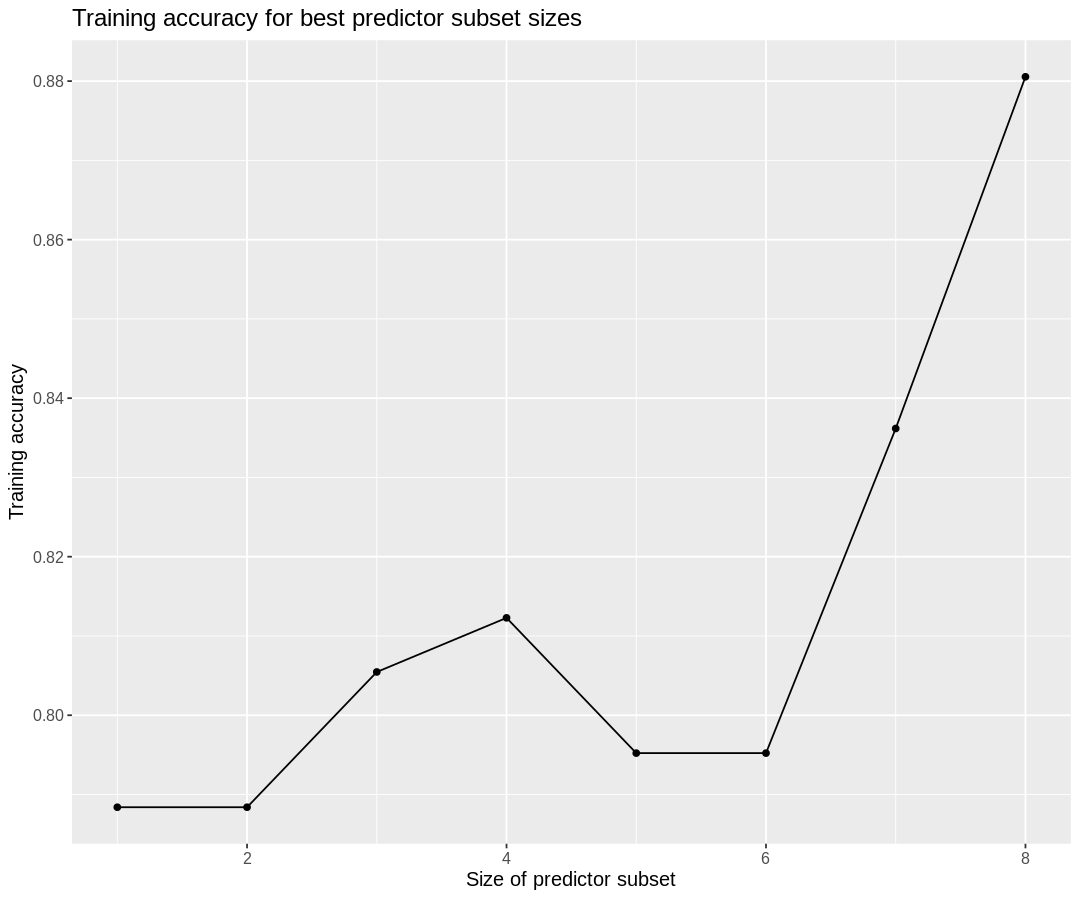

In [28]:
options(repr.plot.height = 7.5, repr.plot.width = 9)

# Create dataframe using subset size and training accuracies
accuracy_data <- data.frame(subset_size, training_accuracies)

# Create plot of subset size vs training accuracy 
accuracy_plot <- ggplot(accuracy_data, aes(x=subset_size, y=training_accuracies)) + 
geom_point() + 
geom_line() + 
labs(x="Size of predictor subset", y="Training accuracy") + 
ggtitle("Training accuracy for best predictor subset sizes") +
theme(text = element_text(size = 12),
      plot.caption = element_text(hjust = 0))

accuracy_plot

**Figure 2.** Model accuracy compared to the number of predictive used in the training subset. Size of subset indicates how many predictors were included and all combinations of predictors were used in each subset. 

After examining our data, we wanted to investigate which combination of predictors gave the highest diagnostic accuracy. To do so, we created a comparison model that tested subset combinations and their predictive accuracy against the known outcome. This was completed using our training data and visualized in the plot above.  

As we can see from above, using all predictors seem to have the best training accuracy. Going forward, we will use all predictors.

In [13]:
# Find test accuracy using all predictors
fitted_model <- get_fitted_model(8, subsets) 
test_accuracy <- get_accuracy(fitted_model, diabetes_test) 
test_accuracy

[1] 0.7676768

Training data was then used to create the classification system. The optimal number of k-nearest neighbours was evaluated by performing 5-fold cross-validation. During this process the data was standardized. 

In [14]:
set.seed(SEED)
diabetes_vfold <- vfold_cv(diabetes_train, v = 5, strata = Outcome)

In [15]:
knn_recipe <- recipe(Outcome ~ ., data = diabetes_train) |>
                  step_scale(all_predictors()) |>
                  step_center(all_predictors())

In [16]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
                set_engine("kknn") |>
                set_mode("classification")

In [17]:
set.seed(SEED)

# testing k = 1 though 20
k_vals <- tibble(neighbors = seq(from = 1, to = 20))

knn_results <- workflow() |>
               add_recipe(knn_recipe) |>
               add_model(knn_spec) |>
               tune_grid(resamples = diabetes_vfold, grid = k_vals) |>
               collect_metrics() |>
               filter(.metric == "accuracy") |>
               arrange(desc(mean))
knn_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
3,accuracy,binary,0.7748393,5,0.02824656,Preprocessor1_Model03
4,accuracy,binary,0.7748393,5,0.02824656,Preprocessor1_Model04
9,accuracy,binary,0.7675959,5,0.02963416,Preprocessor1_Model09
⋮,⋮,⋮,⋮,⋮,⋮,⋮
12,accuracy,binary,0.7574245,5,0.02324299,Preprocessor1_Model12
1,accuracy,binary,0.7407598,5,0.02689972,Preprocessor1_Model01
2,accuracy,binary,0.7407598,5,0.02689972,Preprocessor1_Model02


**Table 7.** Performance of classification algorithms with k-values from 1 - 20. Items have been arranged in descending order based on accuracy.

In [18]:
neighbor <- knn_results |> slice(1) |> pull(neighbors)
neighbor

[1] 3

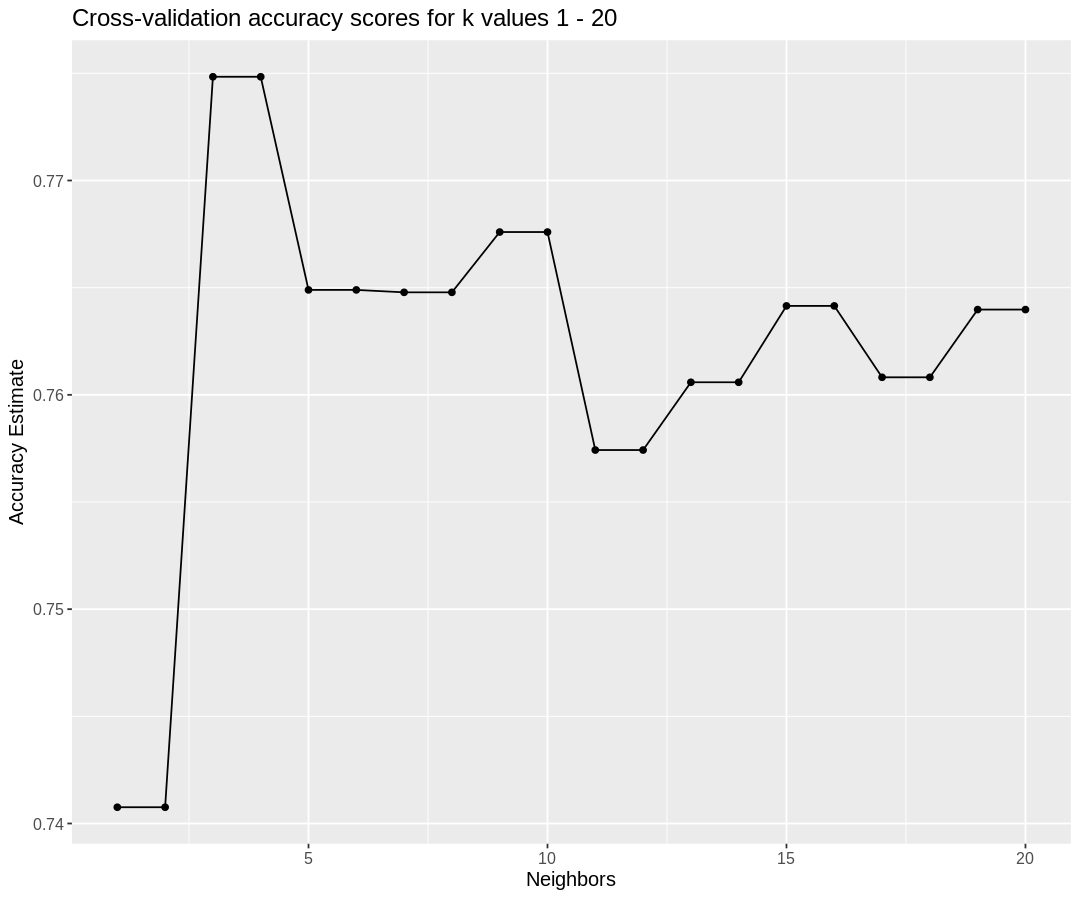

In [19]:
options(repr.plot.height = 7.5, repr.plot.width = 9)

cross_val_plot <- ggplot(knn_results, aes(x = neighbors, y = mean)) +
                    geom_point() +
                    geom_line() +
                    labs(x = "Neighbors", y = "Accuracy Estimate") +
                    ggtitle("Cross-validation accuracy scores for k values 1 - 20") +
                    theme(text = element_text(size = 12)) 

cross_val_plot

**Figure 3.** Relationship between model accuracy and number of neighbours. The model was created using all predictors. Points represent individual values. 

Cross-validation showed $k$= 3 as the optimal parameter for maintaining a high accuracy. A fitted classification model was then derived using training data.

In [20]:
diabetes_recipe <- recipe(Outcome ~., data = diabetes_train)

diabetes_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 3) |>
               set_engine("kknn") |>
               set_mode("classification")

diabetes_fit <- workflow() |>
             add_recipe(diabetes_recipe) |>
             add_model(diabetes_spec) |>
             fit(data = diabetes_train)

diabetes_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(3,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.225256
Best kernel: rectangular
Best k: 3

### Results

Testing data was evaluated using a fitted classification model. Predicted class was compared to original outcome to determine model accuracy on novel data. 

In [21]:
set.seed(SEED) 

diabetes_predictions <- predict(diabetes_fit, diabetes_test) |>
                    bind_cols(diabetes_test)

diabetes_predictions

.pred_class,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,5,166,72,19,175,25.8,0.587,51,1
0,1,103,30,38,83,43.3,0.183,33,0
1,10,125,70,26,115,31.1,0.205,41,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
0,3,102,44,20,94,30.8,0.400,26,0
0,1,109,58,18,116,28.5,0.219,22,0
0,0,181,88,44,510,43.3,0.222,26,1


**Table 8.** A comparison of predicted diagnosis (.pred_class) from all predictors to recorded diagnosis

In [22]:
diabetes_metrics <- diabetes_predictions |> 
                metrics(truth = Outcome, estimate = .pred_class) |>
                filter(.metric == "accuracy")

diabetes_metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7676768


**Table 9.** Model degree of accuracy

.metric = statistic measured; .estimator = measurement type; .estimate = degree of metric

From this table, we can determine that our model has a prediction accuracy of 76.77%

In [23]:
mnist_conf_mat <- diabetes_predictions |>
                    conf_mat(truth = Outcome, estimate = .pred_class)

mnist_conf_mat

          Truth
Prediction  0  1
         0 55 12
         1 11 21

**Table 10.** A signal detection matrix measuring hits (bottom right), misses (top right), false alarms (bottom left) and correct rejections (top left). 

Comparison of model accuracy lines up with the calculated predictive ability estimated earlier in this document. Additional examination of a signal detection matrix reveals a relatively high amount of correct rejections, with a modest amount of hits, aligning with the relatively high accuracy of the model. False alarms and misses are comparatively lower. 

### Discussion

Through best subsets regression, it was determined that using all eight predictors produced the most accurate model, as shown by **Figure 2**, with an accuracy of 88%. 

Although our group expected that certain variables would have more predictive power, literature supports all predictors having an impact on the likelihood of developing diabetes mellitus type 2. It has been established that BMI, age, family history and blood pressure are strong predictors of Type 2 (Diabetes Canada, 2022; World Health Organization, 2022). However, upon further research, there is evidence of the other variables being risk factors in the development of diabetes. 

Gestational diabetes is common in pregnancies and often resolves post-partum, but this is not always the case. Women who have experienced impaired glucose tolerance during pregnancy are at risk for developing diabetes outside of pregnancy (Kim, 2014). Increased skin thickness is also seen in diabetes, most often associated with connective tissue damage and diabetic neuropathy, with severity depending on the length of diabetes duration (Forst et al., 1994). 

Poor glycemic control, typical in diabetes mellitus type 2, can lead to elevated glucose and insulin levels (Diabetes Canada, 2022). As cells lose insulin sensitivity, more of the hormone is needed to maintain regular   blood glucose levels; however, this inability to react to insulin can lead to hyperglycemia. This would explain why Glucose and Insulin have predictive significance. 

As of 2017, 1 in 3 Canadians is either diabetic or prediabetic, with prevalence expected to grow over 40% in the next ten years (Diabetes Canada, 2017). Type 2 diabetes, which accounts for 90% of patients, can be prevented or delayed with early intervention (Diabetes Canada, 2022). Early diagnosis has been shown to significantly increase life expectancy, with health improvements sustained years after the initial intervention (Diabetes Canada, 2017; Holman et al., 2008). Additionally, this could help reduce the high individual and collective costs associated with diabetes; in 2018 insulin accounted for roughly $725 per patient and 484 million of government spending (Schneider et al., 2022).

By determining which factors are strongly predictive measures of diabetes, future studies can focus on factor interactions and longitudinal studies that evaluate the merits of tailored interventions.


### References

Diabetes Canada. (2017). Diabetes Canada 2018 Pre-Budget Submission: 90-90-90 - Measurable change and improved productivity by 2021. Retrieved from Diabetes Canada: https://www.diabetes.ca/DiabetesCanadaWebsite/media/Advocacy-and-Policy/Submissions%20to%20Government/Federal/2018-Federal-PBS.pdf

Diabetes Canada. (2022). Assess your risk of developing diabetes. DiabetesCanadaWebsite. Retrieved October 27, 2022, from https://www.diabetes.ca/type-2-risks/risk-factors---assessments 

Diabetes Canada. (2022). What is diabetes? DiabetesCanadaWebsite. Retrieved October 27, 2022, from https://www.diabetes.ca/about-diabetes/what-is-diabetes 

Forst T, Kann P, Pfützner A, Lobmann R, Schäfer H, Beyer J. (1994). Association between "diabetic thick skin syndrome" and neurological disorders in diabetes mellitus. Acta Diabetol. 31(2), 73-7. https://doi.org/10.1007/BF00570538

Holman, R. R., Paul, S. K., Bethel, M. A., Matthews, D. R., & Neil, H. A. (2008). 10-year follow-up of intensive glucose control in type 2 diabetes. New England Journal of Medicine, 359(15), 1577–1589. https://doi.org/10.1056/nejmoa0806470 

Khare, A. D. (2022, April 8). Diabetes Dataset. Retrieved October 20, 2022, from https://www.kaggle.com/datasets/akshaydattatraykhare/diabetes-dataset.
Version 1

Kim C. (2014). Maternal outcomes and follow-up after gestational diabetes mellitus. Diabet Med, 31(3), 292-301. https://doi.org/10.1111/dme.12382

Schneider, T., Gomes, T., Hayes, K. N., Suda, K. J., & Tadrous, M. (2022). Comparisons of insulin spending and price between Canada and the United States. Mayo Clinic Proceedings, 97(3), 573–578. https://doi.org/10.1016/j.mayocp.2021.11.028 

Spencer Bonilla, G., Rodriguez-Gutierrez, R., & Montori, V. M. (2016). What we don’t talk about when we talk about preventing type 2 diabetes—addressing socioeconomic disadvantage. JAMA Internal Medicine, 176(8), 1053. https://doi.org/10.1001/jamainternmed.2016.2952 

World Health Organization. (n.d.). Diabetes. World Health Organization. Retrieved October 27, 2022, from https://www.who.int/health-topics/diabetes#tab=tab_3 

World Health Organization. (2022, September 16). Diabetes. World Health Organization. Retrieved October 27, 2022, from https://www.who.int/news-room/fact-sheets/detail/diabetes 